In [1]:
!pip install torch pandas numpy matplotlib scikit-learn yfinance ta optuna --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 18.3 MB/s eta 0:00:00


In [2]:
#Imports
import math
import time
import os

# Data Analysis & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Financial Analysis
import yfinance as yf
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator

# Machine Learning & Optimization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import optuna


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set styling for plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

Using device: cuda


In [4]:
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Create a specific folder for your models so they don't clutter your root directory
save_path = '/content/drive/My Drive/Stock_Models/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Created folder: {save_path}")
else:
    print(f"Folder already exists: {save_path}")

Mounted at /content/drive
Folder already exists: /content/drive/My Drive/Stock_Models/


In [5]:
# StockDataset class
class StockDataset:
    def __init__(self, ticker, start_date='2015-01-01', end_date='2024-01-01', window_size=60):
        self.ticker = ticker
        self.window_size = window_size
        self.scaler_X = MinMaxScaler(feature_range=(0, 1))
        self.scaler_y = MinMaxScaler(feature_range=(0, 1))

        # 1. Fetch Data
        print(f"Downloading data for {ticker}...")
        self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

        # 2. Feature Engineering
        self.df = self._add_technical_indicators(self.raw_df)

        # 3. Preprocessing
        self.X, self.y = self._create_sequences()

    def _add_technical_indicators(self, df):
        df = df.copy()
        # Handle MultiIndex columns if yfinance returns them
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        close = df['Close']

        # RSI (Momentum)
        rsi = RSIIndicator(close=close, window=14)
        df['RSI'] = rsi.rsi()

        # MACD (Trend)
        macd = MACD(close=close)
        df['MACD'] = macd.macd()

        # SMA (Smoothing)
        sma = SMAIndicator(close=close, window=20)
        df['SMA_20'] = sma.sma_indicator()

        # Drop NaN values created by indicators
        df = df.dropna()

        # Features to use for prediction
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'SMA_20']
        return df[features]

    def _create_sequences(self):
        data = self.df.values
        target = self.df['Close'].values.reshape(-1, 1)

        # 1. Define the split point ( first 80% is for training)
        train_size = int(len(data) * 0.8)

        # 2. Fit the scaler ONLY on the training portion
        # This calculates mean/std using only past data, preventing leakage
        self.scaler_X.fit(data[:train_size])
        self.scaler_y.fit(target[:train_size])

        # 3. Transform the ENTIRE dataset using those learned parameters
        data_normalized = self.scaler_X.transform(data)
        target_normalized = self.scaler_y.transform(target)

        X, y = [], []
        # Sliding Window Logic
        for i in range(len(data_normalized) - self.window_size):
            # Input: Window of 'window_size' days
            X.append(data_normalized[i:i+self.window_size])
            # Target: The Close price of the NEXT day
            y.append(target_normalized[i+self.window_size])

        return np.array(X), np.array(y)

    def get_loaders(self, batch_size=64):
        # Split 80/10/10
        split1 = int(len(self.X) * 0.8)
        split2 = int(len(self.X) * 0.9)

        X_train, y_train = self.X[:split1], self.y[:split1]
        X_val, y_val = self.X[split1:split2], self.y[split1:split2]
        X_test, y_test = self.X[split2:], self.y[split2:]

        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()),
                                  batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()),
                                batch_size=batch_size)
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()),
                                 batch_size=batch_size)

        return train_loader, val_loader, test_loader, X_train.shape[2]

# RecurrentModel class
class RecurrentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, model_type="LSTM"):
        super(RecurrentModel, self).__init__()
        self.model_type = model_type
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        if model_type == "RNN":
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        if self.model_type == "LSTM":
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# TimeSeriesTransformer class
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :] # Use last token
        output = self.decoder(output)
        return output

# evaluate_model function
def evaluate_model(model, test_loader, scaler_y):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            out = model(x_test).cpu().numpy()
            predictions.append(out)
            actuals.append(y_test.numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Inverse Transform to get actual prices
    predictions_prices = scaler_y.inverse_transform(predictions)
    actuals_prices = scaler_y.inverse_transform(actuals)

    return predictions_prices, actuals_prices


#  train_model with time measurement
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, patience=5):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    start_time = time.time() # Start timer

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_out = model(x_val)
                val_loss = criterion(val_out, y_val)
                val_batch_losses.append(val_loss.item())

        val_loss = np.mean(val_batch_losses)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            full_path = os.path.join(save_path, f"best_{TARGET_TICKER}_{model.__class__.__name__}.pth")
            torch.save(model.state_dict(), full_path)
        else:
            # Only increment patience if the loss did not improve
            patience_counter += 1

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model weights after training
    model.load_state_dict(torch.load(full_path)) # Load the model from the actual saved path
    end_time = time.time() # End timer
    training_duration = end_time - start_time
    return model, train_losses, val_losses, training_duration # Return duration

#  CONFIGURATION (Multi-ticker)
TICKERS = ["NVDA", "KO", "JPM"]
WINDOW = 60
BATCH = 64

# Containers to keep everything per ticker
all_results = {}
all_predictions = {}
all_actuals = {}

for TARGET_TICKER in TICKERS:
    print(f"\n==============================")
    print(f"--- Processing {TARGET_TICKER} ---")
    print(f"==============================\n")

    # 1. Setup Data
    dataset = StockDataset(TARGET_TICKER, window_size=WINDOW)
    train_loader, val_loader, test_loader, input_dim = dataset.get_loaders(batch_size=BATCH)

    # 2. Setup Models
    models_to_train = {
        "RNN": RecurrentModel(input_dim, hidden_dim=64, layer_dim=2, output_dim=1, dropout_prob=0.2, model_type="RNN").to(device),
        "LSTM": RecurrentModel(input_dim, hidden_dim=64, layer_dim=2, output_dim=1, dropout_prob=0.2, model_type="LSTM").to(device),
        "GRU": RecurrentModel(input_dim, hidden_dim=64, layer_dim=2, output_dim=1, dropout_prob=0.2, model_type="GRU").to(device),
        "Transformer": TimeSeriesTransformer(input_dim, d_model=64, nhead=4, num_layers=2, output_dim=1, dropout=0.1).to(device),
    }

    results = {}
    predictions_store = {}
    actuals_store = None

    # 3. Training Loop
    for name, model in models_to_train.items():
        print(f"\n>> Training {name} on {TARGET_TICKER}...")

        # Updated call to train_model to capture training_duration
        trained_model, t_loss, v_loss, training_duration = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=30,
            lr=0.001,
            patience=5
        )

        # Evaluate
        preds, actuals = evaluate_model(trained_model, test_loader, dataset.scaler_y)
        actuals_store = actuals

        # Metrics
        mse = np.mean((preds - actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(preds - actuals))

        # Store training duration AND losses
        results[name] = {"RMSE": rmse, "MAE": mae, "Training_Time_seconds": training_duration, "Train_Losses": t_loss, "Val_Losses": v_loss}
        predictions_store[name] = preds

        print(f"{name} Performance -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | Train Time: {training_duration:.2f}s")

    print("\nAll models trained for", TARGET_TICKER)

    # Persist per-ticker artifacts
    all_results[TARGET_TICKER] = results
    all_predictions[TARGET_TICKER] = predictions_store
    all_actuals[TARGET_TICKER] = actuals_store

print("\nDone. Trained all tickers:", ", ".join(TICKERS))


--- Processing NVDA ---



/tmp/ipython-input-1225018432.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)



>> Training RNN on NVDA...
Epoch 5/30 | Train Loss: 0.000696 | Val Loss: 0.000915
Epoch 10/30 | Train Loss: 0.000439 | Val Loss: 0.001308
Epoch 15/30 | Train Loss: 0.000397 | Val Loss: 0.000824
Early stopping triggered.
RNN Performance -> RMSE: 5.2978 | MAE: 4.4894 | Train Time: 2.66s

>> Training LSTM on NVDA...
Epoch 5/30 | Train Loss: 0.000550 | Val Loss: 0.001741
Epoch 10/30 | Train Loss: 0.000492 | Val Loss: 0.001465
Epoch 15/30 | Train Loss: 0.000348 | Val Loss: 0.001271
Epoch 20/30 | Train Loss: 0.000376 | Val Loss: 0.001026
Epoch 25/30 | Train Loss: 0.000312 | Val Loss: 0.001059
Early stopping triggered.
LSTM Performance -> RMSE: 4.0474 | MAE: 3.3252 | Train Time: 2.71s

>> Training GRU on NVDA...
Epoch 5/30 | Train Loss: 0.000536 | Val Loss: 0.001332
Epoch 10/30 | Train Loss: 0.000432 | Val Loss: 0.001233
Epoch 15/30 | Train Loss: 0.000383 | Val Loss: 0.001117
Epoch 20/30 | Train Loss: 0.000373 | Val Loss: 0.001265
Early stopping triggered.
GRU Performance -> RMSE: 4.3996 | M

/tmp/ipython-input-1225018432.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)



>> Training RNN on KO...
Epoch 5/30 | Train Loss: 0.001529 | Val Loss: 0.003457
Epoch 10/30 | Train Loss: 0.000967 | Val Loss: 0.003705
Epoch 15/30 | Train Loss: 0.000700 | Val Loss: 0.000909
Epoch 20/30 | Train Loss: 0.000780 | Val Loss: 0.001473
Early stopping triggered.
RNN Performance -> RMSE: 0.5532 | MAE: 0.4151 | Train Time: 2.48s

>> Training LSTM on KO...
Epoch 5/30 | Train Loss: 0.001562 | Val Loss: 0.005628
Early stopping triggered.
LSTM Performance -> RMSE: 1.0639 | MAE: 0.8739 | Train Time: 0.62s

>> Training GRU on KO...
Epoch 5/30 | Train Loss: 0.001087 | Val Loss: 0.001361
Epoch 10/30 | Train Loss: 0.000809 | Val Loss: 0.001125
Epoch 15/30 | Train Loss: 0.000784 | Val Loss: 0.001184
Early stopping triggered.
GRU Performance -> RMSE: 0.5735 | MAE: 0.4360 | Train Time: 1.47s

>> Training Transformer on KO...
Epoch 5/30 | Train Loss: 0.003016 | Val Loss: 0.001061
Epoch 10/30 | Train Loss: 0.001673 | Val Loss: 0.000713
Epoch 15/30 | Train Loss: 0.001274 | Val Loss: 0.00078

/tmp/ipython-input-1225018432.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)



>> Training RNN on JPM...
Epoch 5/30 | Train Loss: 0.001247 | Val Loss: 0.000644
Epoch 10/30 | Train Loss: 0.000815 | Val Loss: 0.000517
Epoch 15/30 | Train Loss: 0.000710 | Val Loss: 0.000559
Epoch 20/30 | Train Loss: 0.000569 | Val Loss: 0.000414
Epoch 25/30 | Train Loss: 0.000571 | Val Loss: 0.001206
Early stopping triggered.
RNN Performance -> RMSE: 2.3861 | MAE: 1.8475 | Train Time: 2.99s

>> Training LSTM on JPM...
Epoch 5/30 | Train Loss: 0.001164 | Val Loss: 0.001337
Epoch 10/30 | Train Loss: 0.001145 | Val Loss: 0.001055
Early stopping triggered.
LSTM Performance -> RMSE: 3.1953 | MAE: 2.5166 | Train Time: 1.76s

>> Training GRU on JPM...
Epoch 5/30 | Train Loss: 0.001074 | Val Loss: 0.000939
Epoch 10/30 | Train Loss: 0.000807 | Val Loss: 0.000825
Epoch 15/30 | Train Loss: 0.000730 | Val Loss: 0.000731
Epoch 20/30 | Train Loss: 0.000653 | Val Loss: 0.000689
Epoch 25/30 | Train Loss: 0.000556 | Val Loss: 0.000651
Epoch 30/30 | Train Loss: 0.000573 | Val Loss: 0.000648
GRU Perf

In [6]:
import joblib
import os
import pandas as pd


summary_rows = []
for ticker, res in all_results.items():
    for model_name, metrics in res.items():
        summary_rows.append({
            "Ticker": ticker,
            "Model": model_name,
            "RMSE": metrics["RMSE"],
            "MAE": metrics["MAE"],
            "Training Time (s)": metrics["Training_Time_seconds"]
        })

summary_df = pd.DataFrame(summary_rows)

summary_df.to_csv(os.path.join(save_path, "final_summary_report.csv"), index=False)

joblib.dump(dataset.scaler_X, os.path.join(save_path, f"{TARGET_TICKER}_scaler_X.pkl"))
joblib.dump(dataset.scaler_y, os.path.join(save_path, f"{TARGET_TICKER}_scaler_y.pkl"))

print("All models and scalers saved to Google Drive.")

All models and scalers saved to Google Drive.


,Ticker,Model,RMSE,MAE,Training Time (s)
7,KO,Transformer,0.534416,0.418810,4.150757
4,KO,RNN,0.553188,0.415059,2.483880
6,KO,GRU,0.573513,0.435999,1.474921
5,KO,LSTM,1.063935,0.873906,0.615007
8,JPM,RNN,2.386058,1.847488,2.994192
10,JPM,GRU,2.411200,1.836209,2.576277
11,JPM,Transformer,2.541627,1.879955,6.011757
9,JPM,LSTM,3.195308,2.516611,1.763089
1,NVDA,LSTM,4.047382,3.325166,2.705502
2,NVDA,GRU,4.399599,3.677345,1.889824


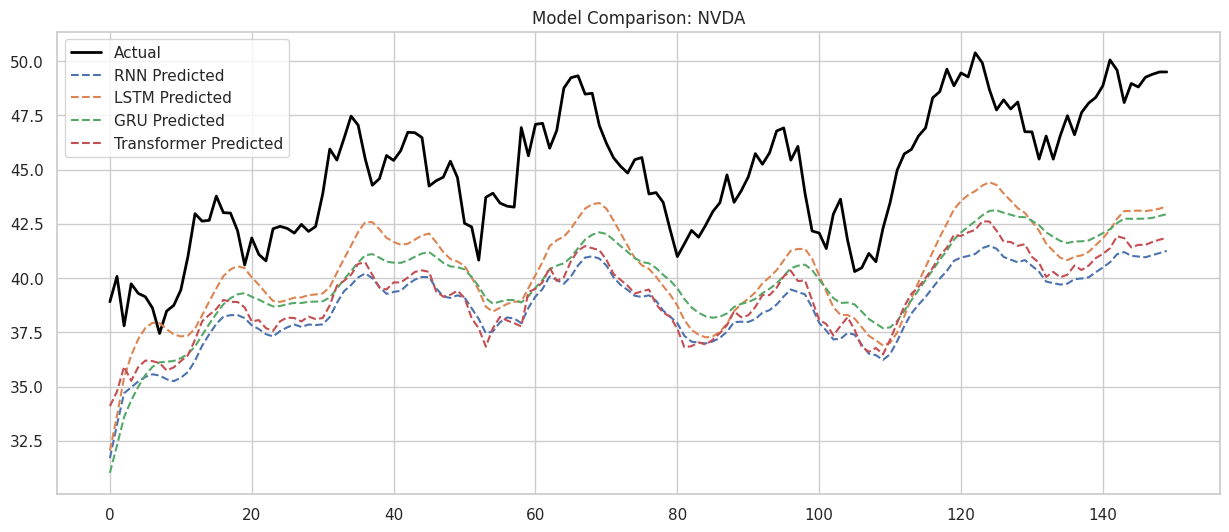

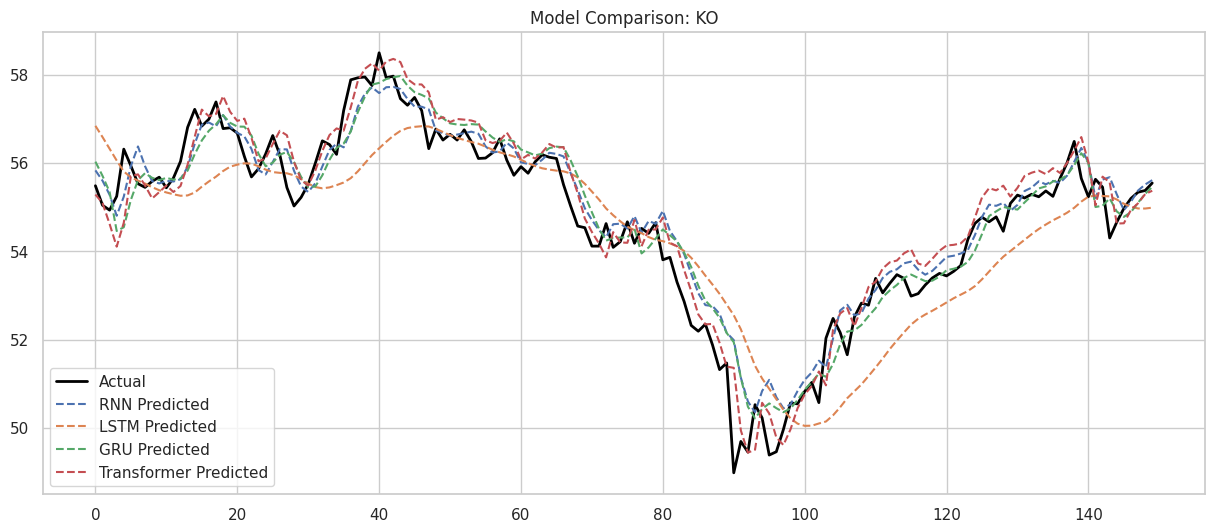

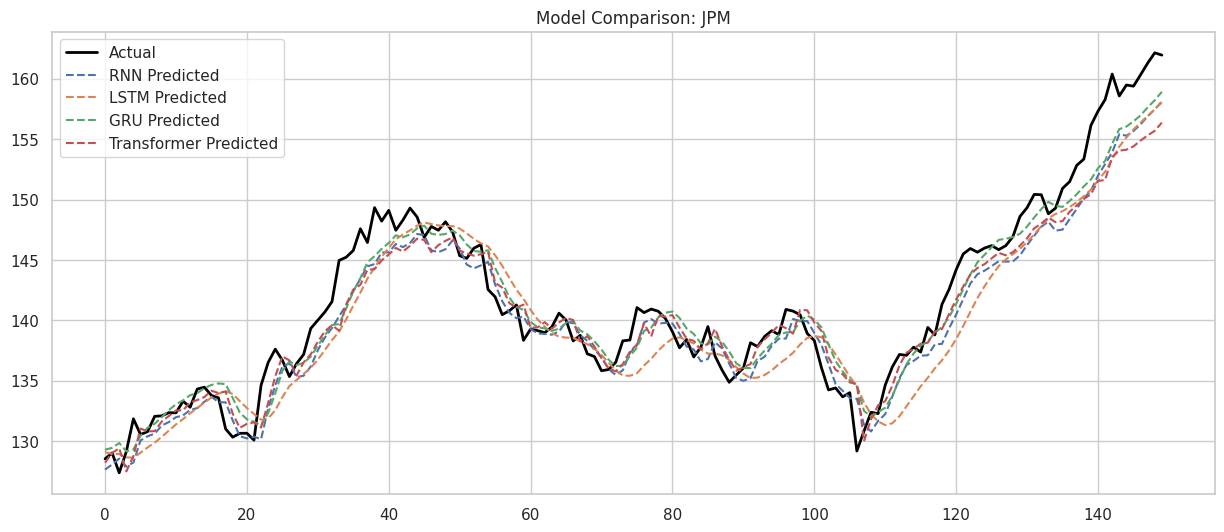


--- Summary of Model Performance and Training Times ---


,Ticker,Model,RMSE,MAE,Training Time (s)
8,JPM,RNN,2.386058,1.847488,2.994192
10,JPM,GRU,2.411200,1.836209,2.576277
11,JPM,Transformer,2.541627,1.879955,6.011757
9,JPM,LSTM,3.195308,2.516611,1.763089
7,KO,Transformer,0.534416,0.418810,4.150757
4,KO,RNN,0.553188,0.415059,2.483880
6,KO,GRU,0.573513,0.435999,1.474921
5,KO,LSTM,1.063935,0.873906,0.615007
1,NVDA,LSTM,4.047382,3.325166,2.705502
2,NVDA,GRU,4.399599,3.677345,1.889824


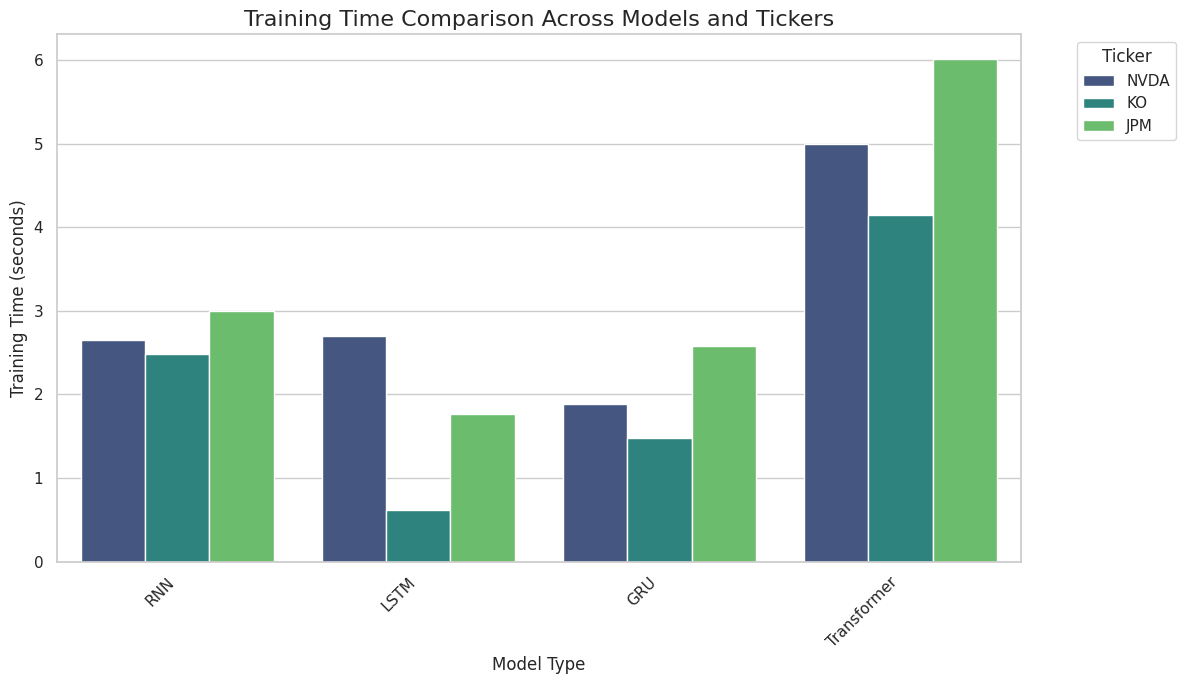

In [7]:
# VISUALIZATION
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the Summary Data
report_path = os.path.join(save_path, "final_summary_report.csv")
if os.path.exists(report_path):
    viz_df = pd.read_csv(report_path)
    display(viz_df.sort_values("RMSE"))

# 2. Visualizing specific predictions

for TARGET_TICKER in TICKERS:
    plt.figure(figsize=(15, 6))
    plt.plot(all_actuals[TARGET_TICKER][-150:], label="Actual", color='black', lw=2)

    for model_name in all_results[TARGET_TICKER].keys():
        preds = all_predictions[TARGET_TICKER][model_name]
        plt.plot(preds[-150:], label=f"{model_name} Predicted", linestyle="--")

    plt.title(f"Model Comparison: {TARGET_TICKER}")
    plt.legend()
    plt.show()


 #  PLOTTING

# Optional: summary table across tickers (rows=tickers, columns=model-metric)
summary_rows = []
for ticker, res in all_results.items():
    for model_name, metrics in res.items():
        summary_rows.append({
            "Ticker": ticker,
            "Model": model_name,
            "RMSE": metrics["RMSE"],
            "MAE": metrics["MAE"],
            "Training Time (s)": metrics["Training_Time_seconds"]
        })

summary_df = pd.DataFrame(summary_rows)
print("\n--- Summary of Model Performance and Training Times ---")
display(summary_df.sort_values(["Ticker", "RMSE"]))

# Plotting training times
plt.figure(figsize=(12, 7))
sns.barplot(data=summary_df, x="Model", y="Training Time (s)", hue="Ticker", palette="viridis")
plt.title("Training Time Comparison Across Models and Tickers", fontsize=16)
plt.ylabel("Training Time (seconds)", fontsize=12)
plt.xlabel("Model Type", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


